In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering

In [3]:
import sys

sys.path.append('../src')



In [4]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering, box_clustering
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster as ATTC, predict_cf, calculate_ite, get_homogeneity, generate_paths



In [5]:
np.random.seed(seed = 0)

In [6]:
pd.set_option("display.max_columns", None)


### Generate Experiment

In [7]:
%%time
N,D = 2*10**5, 2
x = int((N)**(1/4))
clusters = x**2
print("Number of Clusters:{}, Number of Points:{}".format(clusters, N))
kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
kw_cluster =  {'f_class_name':'circle_class', 'centers': [0.5, 0.5], 'r_small': 0.2, 'r_big':0.4}
kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

std = 3
stats = np.array([[1, std], [0, std], [1, std], [1, std]])
kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

data = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
data = calculate_ite(data.copy(), treatment = 'Treatment',
                     counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')

Number of Clusters:441, Number of Points:200000
CPU times: user 172 ms, sys: 44.2 ms, total: 216 ms
Wall time: 216 ms


In [8]:
data.describe()

,x0,x1,C,Treatment,Y,Ycf,ITE
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.499785,0.499334,0.376745,0.501805,0.808251,0.817695,0.378887
std,0.288533,0.289177,0.484571,0.499998,3.028518,3.024437,4.275750
min,0.000003,0.000003,0.000000,0.000000,-14.006896,-13.126025,-19.753568
25%,0.249671,0.247699,0.000000,0.000000,-1.231169,-1.225523,-2.513573
50%,0.501024,0.498865,0.000000,1.000000,0.822527,0.816021,0.377156
75%,0.749132,0.750450,1.000000,1.000000,2.856275,2.856936,3.265237
max,0.999990,0.999999,1.000000,1.000000,14.152514,15.149986,19.867639


In [9]:
mpl.style.use(['seaborn-paper'])
#mpl.rcParams.update(mpl.rcParamsDefault)


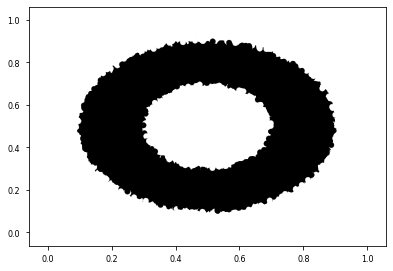

In [10]:
fig, ax = plt.subplots()

ax.scatter(data['x0'].values, data['x1'].values, c=data['C'].values, cmap = 'Greys')


plt.show()

In [55]:
%%time
f1_kwargs = {'n_estimators':400, 'max_depth':18}
f2_kwargs = {'n_estimators':400, 'max_depth':18}

data, models = predict_cf(data.copy(), col_select = ['x0', 'x1'], f1 = GDBR,
                          f2 = GDBR, cf_name = 'Ycf-GDBR', f1_kwargs=f1_kwargs, 
                          f2_kwargs=f2_kwargs, ite_name ='ITE-GDBR')

CPU times: user 5min 7s, sys: 73.1 ms, total: 5min 7s
Wall time: 5min 7s


In [56]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster
0,0.548814,0.715189,1,0,-0.512908,1.799287,2.312196,0,1.686017,2.198926,326
1,0.602763,0.544883,0,1,2.624598,2.752871,-0.128273,0,1.474842,1.149756,243
2,0.423655,0.645894,0,0,3.801295,-1.081036,-4.882331,0,0.627784,-3.173511,281
3,0.437587,0.891773,1,1,2.324851,-0.667582,2.992433,0,0.033044,2.291807,387
4,0.963663,0.383442,0,0,-3.282097,0.683705,3.965803,0,-3.128714,0.153383,188


### Model performance

In [57]:
filt = (data['Treatment'] == 1) & (data['C'] == 1) & (data['IS_TEST'] ==0)
data.groupby(['Treatment', 'C'])[['Y', 'Ycf', 'Ycf-GDBR','ITE', 'ITE-GDBR']].mean()

Y       Ycf  Ycf-GDBR       ITE  ITE-GDBR
Treatment C                                                  
0         0  1.006056  1.000371  0.996454 -0.005685 -0.009603
          1 -0.029535  1.014400  0.997527  1.043936  1.027062
1         0  1.000539  1.013895  0.971563 -0.013356  0.028977
          1  0.996986 -0.002160  0.022792  0.999146  0.974193

### Apply clustering 

In [58]:
%%time
col_select = ['x0', 'x1']
data,_ = box_clustering(data.copy(), clusters = clusters, col_select = col_select )


CPU times: user 14.3 ms, sys: 8.97 ms, total: 23.3 ms
Wall time: 21.8 ms


In [59]:
data.head()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster
0,0.548814,0.715189,1,0,-0.512908,1.799287,2.312196,0,1.686017,2.198926,326
1,0.602763,0.544883,0,1,2.624598,2.752871,-0.128273,0,1.474842,1.149756,243
2,0.423655,0.645894,0,0,3.801295,-1.081036,-4.882331,0,0.627784,-3.173511,281
3,0.437587,0.891773,1,1,2.324851,-0.667582,2.992433,0,0.033044,2.291807,387
4,0.963663,0.383442,0,0,-3.282097,0.683705,3.965803,0,-3.128714,0.153383,188


### Calculte ATT PER Cluster  known CF

$
\begin{align}
E[Y^1|T=1,Ci ]-E[Y^0|T=1, Ci]
\end{align}
$

In [60]:
ite_name = 'ITE'
box = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', 
           ITE_name = ite_name, hom_name = 'Box-Hom',
          att = False)



In [61]:
box

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
0,0,0.323570,255.0,1.0,0.002541
1,1,-0.051649,219.0,1.0,0.002182
2,2,0.190121,232.0,1.0,0.002312
3,3,-0.329806,204.0,1.0,0.002033
4,4,-0.187287,216.0,1.0,0.002152
...,...,...,...,...,...
436,436,0.006574,252.0,1.0,0.002511
437,437,-0.516302,220.0,1.0,0.002192
438,438,0.233827,214.0,1.0,0.002132
439,439,-0.109683,223.0,1.0,0.002222


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


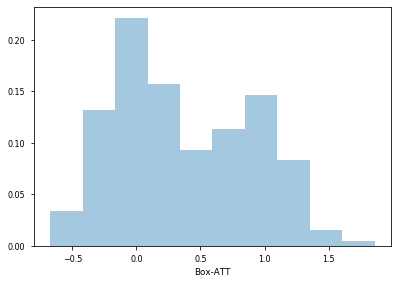

In [62]:
kde = False
bins = 10
sns.distplot(box['Box-ATT'], hist_kws={'weights':box['Box-Weights'].values},bins = bins, kde = kde)
plt.show()

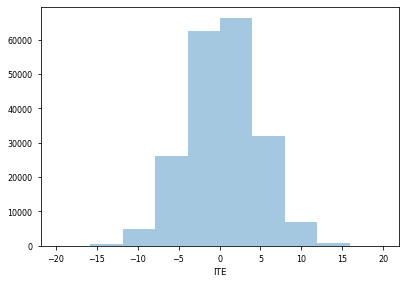

In [63]:
sns.distplot(data['ITE'], bins = 10, kde = kde)
plt.show()

In [64]:
box.describe()

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
count,441.00000,441.000000,441.000000,441.000000,441.000000
mean,220.00000,0.367637,227.575964,0.954325,0.002268
std,127.44999,0.538163,14.680205,0.111234,0.000146
min,0.00000,-0.673600,186.000000,0.509524,0.001853
25%,110.00000,-0.079936,218.000000,1.000000,0.002172
50%,220.00000,0.247574,227.000000,1.000000,0.002262
75%,330.00000,0.846753,237.000000,1.000000,0.002361
max,440.00000,1.861148,278.000000,1.000000,0.002770


### Calculate ATT per Cluster not known Model Calculated CF

In [65]:
ite_name = 'ITE-GDBR'
box2 = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', ITE_name = ite_name, hom_name = 'Box-Hom')


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


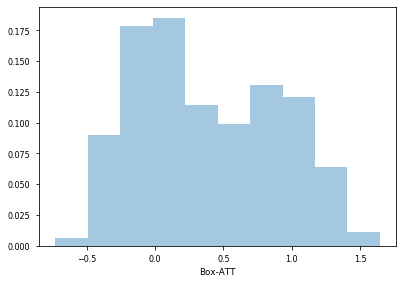

In [66]:
kde = False
bins = 10
sns.distplot(box2['Box-ATT'], hist_kws={'weights':box2['Box-Weights'].values},bins = bins, kde = kde, )
plt.show()

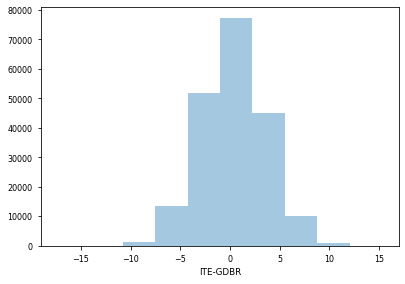

In [67]:
sns.distplot(data['ITE-GDBR'],bins = bins, kde = kde)
plt.show()

### Weighted Kmeans 2-Clustering

In [68]:
%%time
#all_data = [box, kmeans, agglo, box2, kmeans2, agglo2]
all_data = [box, box2]

#names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']
#names2 = ['Box-ATT', 'Kmeans-ATT', 'Agglo-ATT', 'Box-ATT', 'Kmeans-ATT', 'Agglo-ATT']

names = ['Box-Cl2', 'Box2-Cl2']
names2 = ['Box-ATT', 'Box-ATT']

weights = ['Box-Weights', 'Box-Weights']

for dd, name, name2,w in zip(all_data, names, names2, weights):
    kmeans_clustering(dd, clusters = 2, col_select = [name2], 
                      cluster_name = name, fit_kwargs={'sample_weight':dd[w].values} )

CPU times: user 112 ms, sys: 2 ms, total: 114 ms
Wall time: 58.1 ms


In [69]:
data2 = data.copy()

In [70]:
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster
0,0.548814,0.715189,1,0,-0.512908,1.799287,2.312196,0,1.686017,2.198926,326
1,0.602763,0.544883,0,1,2.624598,2.752871,-0.128273,0,1.474842,1.149756,243


### 2 Clustering in the ITEs

In [71]:
data2,_ = kmeans_clustering(data2,clusters = 2, cluster_name = 'ITE-CTrue',col_select = ['ITE'] )
data2,_ = kmeans_clustering(data2,clusters = 2, cluster_name = 'ITE-CGDBR',col_select = ['ITE-GDBR'] )

### Clustering for Drawing 
1. Apply Box clustering to separate the space in K clusters
2. Group by this clusters and get the Average C2-Avg from the 2 clustering
3. Color each box with the C2-Avg corresponding to each box

In [72]:
K = 10**4
data2,_ = box_clustering(data2, clusters = K, cluster_name = 'C2-Avg', col_select = col_select)

In [73]:
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,ITE-CTrue,ITE-CGDBR,C2-Avg
0,0.548814,0.715189,1,0,-0.512908,1.799287,2.312196,0,1.686017,2.198926,326,1,1,7154
1,0.602763,0.544883,0,1,2.624598,2.752871,-0.128273,0,1.474842,1.149756,243,0,1,5460


In [74]:
box.head(2)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights,Box-Cl2
0,0,0.323570,255.0,1.0,0.002541,0
1,1,-0.051649,219.0,1.0,0.002182,0


### Merge 2 Clustering with initial data

In [75]:
#merge_names = ['Box-Cluster', 'Kmeans-Cluster', 'Agglomerative-Cluster']*2
#class_names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']

merge_names = ['Box-Cluster']*2
class_names = ['Box-Cl2',  'Box2-Cl2']

for dd, merge_name, class_name in zip(all_data, merge_names, class_names):
    dd2 = dd[[merge_name, class_name]]


    data2 = data2.merge(dd2, on = merge_name, how = 'left' )

### Find Average 2 Clustering per draw cluster and merge them in the initial dataset

In [76]:
#merge_names = ['Box-Cluster', 'Kmeans-Cluster', 'Agglomerative-Cluster']*2
#class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2',
            #    'Agglo2-Cl2','ITE-CTrue', 'ITE-CGDBR']
class_names = ['Box-Cl2', 'Box2-Cl2',
                 'ITE-CTrue', 'ITE-CGDBR']
avg_c = data2.groupby('C2-Avg', sort = True)[class_names].mean().reset_index()
data2 = data2.merge(avg_c, on = 'C2-Avg', how = 'left', suffixes=("","y"))

In [77]:
avg_c.head()

,C2-Avg,Box-Cl2,Box2-Cl2,ITE-CTrue,ITE-CGDBR
0,0,0.0,0.0,0.428571,0.428571
1,1,0.0,0.0,0.523810,0.476190
2,2,0.0,0.0,0.450000,0.350000
3,3,0.0,0.0,0.368421,0.263158
4,4,0.0,0.0,0.419355,0.290323


In [78]:
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,ITE-CTrue,ITE-CGDBR,C2-Avg,Box-Cl2,Box2-Cl2,Box-Cl2y,Box2-Cl2y,ITE-CTruey,ITE-CGDBRy
0,0.548814,0.715189,1,0,-0.512908,1.799287,2.312196,0,1.686017,2.198926,326,1,1,7154,1,1,0.789474,0.789474,0.526316,0.578947
1,0.602763,0.544883,0,1,2.624598,2.752871,-0.128273,0,1.474842,1.149756,243,0,1,5460,0,0,0.000000,0.000000,0.176471,0.352941


### Plot reconstruction of data

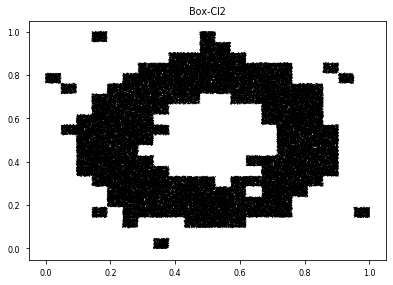

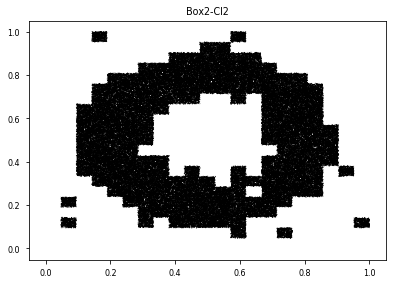

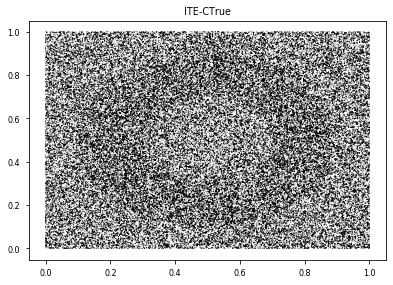

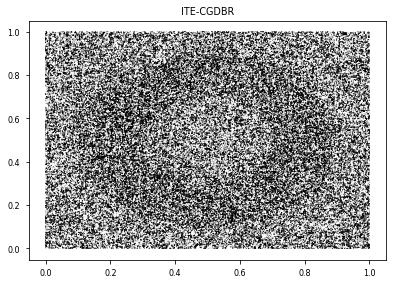

CPU times: user 19.4 s, sys: 675 ms, total: 20.1 s
Wall time: 19.2 s


In [79]:
%%time
#class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2',
                #'Kmeans2-Cl2', 'Agglo2-Cl2', 'ITE-CTrue', 'ITE-CGDBR']

class_names1 = ['Box-Cl2', 'Box2-Cl2',
                 'ITE-CTrue', 'ITE-CGDBR']

class_names2 = [name+'y' for name in class_names1]
use_poly = False
for name in class_names1:
    #data2.plot.scatter(x='x0', y='x1', c=name, colormap='inferno')
    fig, ax = plt.subplots()
    if not use_poly:
        sc = ax.scatter(data2['x0'].values, data2['x1'].values, c=data2[name].values, cmap = 'Greys', s = 1)
    else:
        polygons, colors = generate_paths(K, Cdraw = avg_c, Cdraw_name=name)
        coll = mpl.collections.PolyCollection(polygons)
        coll.set(array = np.array(colors), cmap = 'Greys')
        ax.add_collection(coll)
        ax.figure.colorbar(coll)
    ax.set_title(name)
    #fig.colorbar(sc)

    plt.show()
    

### Plot same as above but with box averaging

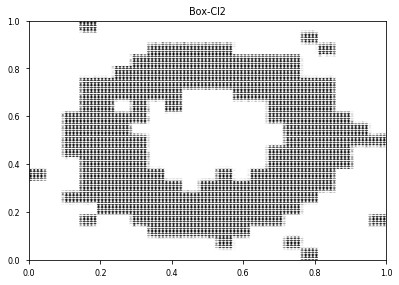

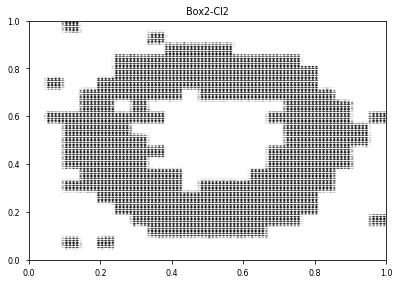

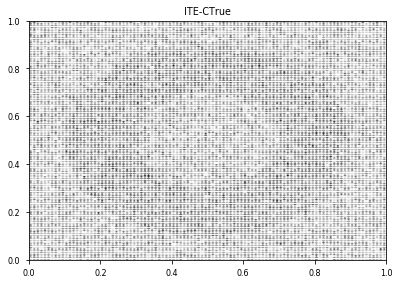

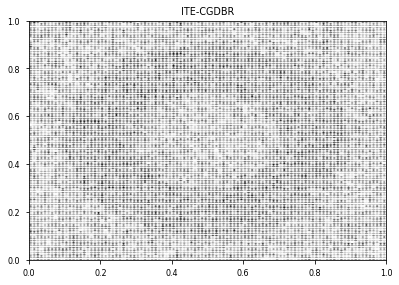

CPU times: user 2.25 s, sys: 35.9 ms, total: 2.28 s
Wall time: 2.28 s


In [81]:
%%time
#class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2',
                #'Kmeans2-Cl2', 'Agglo2-Cl2', 'ITE-CTrue', 'ITE-CGDBR']

class_names1 = ['Box-Cl2', 'Box2-Cl2',
                 'ITE-CTrue', 'ITE-CGDBR']

class_names2 = [name+'y' for name in class_names1]
use_poly = True
for name in class_names1:
    #data2.plot.scatter(x='x0', y='x1', c=name, colormap='inferno')
    fig, ax = plt.subplots()
    if not use_poly:
        sc = ax.scatter(data2['x0'].values, data2['x1'].values, c=data2[name].values, cmap = 'Greys', s = 0.25)
    else:
        polygons, colors = generate_paths(K, Cdraw = avg_c, Cdraw_name=name)
        coll = mpl.collections.PolyCollection(polygons)
        coll.set(array = np.array(colors), cmap = 'Greys')
        ax.add_collection(coll)
       # ax.figure.colorbar(coll)
    ax.set_title(name)
    #fig.colorbar(sc)

    plt.show()
    

### homogeneity experiment

clusters = [4, 16, 25, 100]
clustering_algo = ['box_clustering', 'kmeans_clustering', 'agglomerative_clustering']

result = get_homogeneity(data.copy(),clusters = clusters, clustering_algo = clustering_algo, col_select = col_select)

pd.DataFrame(result)